<a target="_blank" href="https://colab.research.google.com/github/AndreiSokolovskii/google_colab_for_rf2aa/blob/main/RoseTTAFold_All_Atom.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **RoseTTAFold-All-Atom**

**Introduction.**
*   The notebook is still in development.
*   At this moment, the following  prediction regimes are available:


1.   Sequence ⇒ 3D Protein structure:  **with**/**without** templates, and **with**/**without** MSA.
2.   Sequence + small molecule ⇒ 3D complex structure: **with**/**without** templates, and **with**/**without** MSA.


**Important notice**
* Do not use dot symbols in the name of **jobname**
* ***Run all*** from the first attempt is not supported yet.
* The installation process causes a message saying *Your session crashed for an unknown reason.*
* Do not worry. Just tap **Run all** again after this message.





In [ ]:
#@title ##Installation required libraries, downloading RFaa2 weights, and applying some patches
#@markdown This step can take up to ~8 mins
%%capture
import os
from google.colab import files
import re
import hashlib
import random

if not os.path.isfile("CONDACOLAB_READY"):
  !pip install -q condacolab
  import condacolab
  condacolab.install()
  os.system("touch CONDACOLAB_READY")

if not os.path.isfile("ADDITIONAL_SOFT"):
  !mamba install -y -c conda-forge -c bioconda -c predector -c pyg -c pytorch -c nvidia -c biocore kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 openbabel=3.1.1  deepdiff=6.7.1 icecream=2.1.3 assertpy=1.1  dgl=1.1.2 pdbfixer
  !mamba install -y openbabel -c conda-forge
  !pip install hydra-core
  !pip install assertpy==1.1
  !pip install icecream
  !pip install biopython==1.79
  import locale
  locale.getpreferredencoding = lambda: "UTF-8"
  %shell pip install -q py3Dmol
  os.system("pip install --no-dependencies e3nn==0.3.3 opt_einsum_fx")
  if not os.path.exists('lib'):
    os.mkdir('lib')
  os.system('cd lib; wget https://github.com/AndreiSokolovskii/google_colab_for_rf2aa/raw/main/lib.tar; tar -xf lib.tar; rm lib.tar')
  os.system('touch ADDITIONAL_SOFT')

USE_TEMPLATES = False #
if USE_TEMPLATES and not os.path.isfile('USE_TEMPLATES_READY'):
  !conda install bioconda::ffindex
  os.system('touch USE_TEMPLATES_READY')
if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")

if not os.path.isfile('RF2AA_READY'):
  os.system("git clone https://github.com/baker-laboratory/RoseTTAFold-All-Atom.git")
  os.system("cd RoseTTAFold-All-Atom/rf2aa/SE3Transformer; pip install .")
  os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")
  os.system("wget http://files.ipd.uw.edu/pub/RF-All-Atom/weights/RFAA_paper_weights.pt")
  os.system('touch RF2AA_READY')

# GitHub_tocken = "Your_token" #@param {type:"string"}

# os.system(f'git clone https://{GitHub_tocken}@github.com/Cenoten/vorobieva_lab.git')

# from vorobieva_lab.RF2aa_google_colab.add.patch_run import main as patch_run
# patch_run()
if not os.path.isfile('PATCH_READY'):
  os.system('wget https://raw.githubusercontent.com/AndreiSokolovskii/google_colab_for_rf2aa/main/rf2aa_patch.patch -O RoseTTAFold-All-Atom/rf2aa_patch.patch')
  os.system('cd RoseTTAFold-All-Atom; git apply rf2aa_patch.patch')
  os.system('rm RoseTTAFold-All-Atom/rf2aa_patch.patch')
  os.system('touch PATCH_READY')


if not os.path.isfile('NUM_RUNS'):
  os.system('echo 0 > NUM_RUNS')


In [ ]:
#@title ##Some preparations
#@markdown ##Regime choice.
import colabfold_utils as cf
import os
import yaml
num_run = int(os.popen('tail -1 NUM_RUNS').read().strip())
regime = "Protein Monomers" #@param ["Protein Monomers", "Protein Small Molecule Complexes"]
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence"]
USE_TEMPLATES = False #@param {type:"boolean"}
sequence = "PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK" #@param {type:"string"}
sequence = sequence.translate(str.maketrans('', '', ' \n\t')).upper()

# @markdown ---
# @markdown ###  In case of "Protein Small Molecule Complexes" enter a SMILES string:
smiles = ""#@param {type:"string"}
# @markdown ###  or just leave the field above empty and upload an SDF file.

# @markdown ---
prefix = cf.get_hash(sequence)
jobname = "test" #@param {type:"string"}
to_get_msa = jobname
jobname += "_"+cf.get_hash(sequence)[:5]
# jobname += "_" + str(num_run)
config_name = jobname +"_" + str(num_run)
if not os.path.exists(jobname):
    os.mkdir(jobname)

if not os.path.exists('output'):
  os.mkdir('output')
if not os.path.exists(f'output/{str(num_run)}'):
  os.mkdir(f'output/{str(num_run)}')


path_to_conf = "RoseTTAFold-All-Atom/rf2aa/config/inference"
if regime == "Protein Monomers":
  if not os.path.exists(f"{path_to_conf}/{jobname}.yaml"):
    with open(f'{path_to_conf}/protein.yaml') as f:
        doc = yaml.safe_load(f)
        doc['defaults'] += ['_self_']
        doc['job_name'] = jobname
        doc['protein_inputs']['A']['fasta_file'] = jobname + "/" + config_name + '.fasta'
    with open(f"{path_to_conf}/{config_name}.yaml", "w") as new_file:
        yaml.dump(doc, new_file)
elif regime == "Protein Small Molecule Complexes":

  if len(smiles) < 1 and not os.path.exists(f'{jobname}/{config_name}.sdf'):
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
      os.rename(fn,f'{jobname}/{config_name}.sdf')
      os.system(f'cp {jobname}/{config_name}.sdf output/{str(num_run)}/{fn}')
  # elif len(smiles) > 0:
  #   with open(f'{jobname}/{jobname}.smiles','w') as f:
  #     f.write(smiles)

  # if not os.path.exists(f"{path_to_conf}/{jobname}.yaml"):
  with open(f'{path_to_conf}/protein_sm.yaml') as f:
        doc = yaml.safe_load(f)
        doc['defaults'] += ['_self_']
        doc['job_name'] = jobname
        doc['protein_inputs']['A']['fasta_file'] = jobname + "/" + config_name + '.fasta'
        if len(str(smiles)) < 1:
          doc['sm_inputs']['B']['input'] = jobname + "/" + config_name + '.sdf'
          doc['sm_inputs']['B']['input_type'] = "sdf"
        else:
          doc['sm_inputs']['B']['input'] = smiles
          doc['sm_inputs']['B']['input_type'] = "smiles"
          if not os.path.isfile(f'output/{str(num_run)}/input.smiles'):
            with open(f'output/{str(num_run)}/input.smiles','w') as f:
              f.write(f"{smiles}\n")
  with open(f"{path_to_conf}/{config_name}.yaml", "w") as new_file:
        yaml.dump(doc, new_file)
  if not USE_TEMPLATES:
    if not os.path.exists(f"{path_to_conf}/base_defaults.yaml"):
      os.system(f'cp {path_to_conf}/base.yaml {path_to_conf}/base_defaults.yaml')


    with open(f"{path_to_conf}/base.yaml") as f:
        doc = yaml.safe_load(f)
        doc['loader_params']['n_templ'] = 1
    with open(f"{path_to_conf}/tmp.yaml", "w") as new_file:
        yaml.dump(doc, new_file)
    os.rename(f"{path_to_conf}/tmp.yaml", f"{path_to_conf}/base.yaml")
  else:
    if os.path.exists(f"{path_to_conf}/base_defaults.yaml"):
      os.system(f'cp {path_to_conf}/base_defaults.yaml {path_to_conf}/base.yaml')


with open(f"{jobname}/{config_name}.fasta","w") as fasta:
    fasta.write(f">{jobname}\n{sequence}\n")

if not os.path.isfile(f'output/{str(num_run)}/input.fasta'):
  with open(f'output/{str(num_run)}/input.fasta','w') as f:
    f.write(f">{jobname}\n{sequence}\n")



In [ ]:
#@title ## Run search against genetic databases and RoseTTAFold-All-Atom Prediction
if USE_TEMPLATES and not os.path.exists(f'{jobname}/A/t000_.hhr') and not os.path.exists(f'{jobname}/A/t000_.atab'):
    import sys
    sys.path.append('lib')
    from get_msa_and_templates import main as gms
    jobname_templ = gms(sequence, to_get_msa, USE_TEMPLATES, msa_method)
    if os.path.exists('inputForFFINDEX'):
        os.system('rm -r inputForFFINDEX')
    os.system('mkdir inputForFFINDEX')
    os.system('mkdir inputForFFINDEX/splitCh')
    os.system('mkdir inputForFFINDEX/final')
    os.system(f'tail -n +2 {jobname}/{jobname}.a3m > tmp && mv tmp {jobname}/A/t000_.msa0.a3m')
    from cif2pdb import main as cif2pdb
    import glob
    from Bio.PDB import PDBParser
    from Bio.PDB.PDBIO import PDBIO

    parser = PDBParser(QUIET=True)
    io = PDBIO()

    for item in glob.glob(f'{jobname}/{jobname}*/templates_101/*.cif'):
        pdbname = item.split('/')[-1].split('.')[0]
    # print((item, pdbname))
        cif2pdb(item, f'inputForFFINDEX/{pdbname}.pdb')

    def split_chains(filename, id):
        structure = parser.get_structure(id, filename)
        pdb_chains = structure.get_chains()
        for chain in pdb_chains:
            io.set_structure(chain)
            name = structure.get_id() + "_" + chain.get_id() + ".pdb"
            io.save('inputForFFINDEX/splitCh/' + name)
    for item in glob.glob('inputForFFINDEX/*.pdb'):
        id = item.split('/')[-1].split('.')[0]
        split_chains(item, id)
    os.system('''cd /content/inputForFFINDEX/splitCh/; for file in *.pdb; do grep "^ATOM" $file > /content/inputForFFINDEX/final/$file; echo "TER" >>  /content/inputForFFINDEX/final/$file; done''')
    for item in glob.glob('/content/inputForFFINDEX/final/*.pdb'):
      new_name = item.split('.')[0]
      os.rename(item, new_name)
    os.system(f'ffindex_build -s  {jobname}/A/t000_pdb.ffdata  {jobname}/A/t000_pdb.ffindex inputForFFINDEX/final/')

if not USE_TEMPLATES:
  import sys
  sys.path.append('lib')
  from get_msa_and_templates import main as gms
  jobname_templ = gms(sequence, to_get_msa, USE_TEMPLATES, msa_method)
  if not os.path.exists(f'{jobname}/A'):
    os.system(f'mkdir {jobname}/A')
  os.system(f'tail -n +2 {jobname}/{jobname}.a3m > tmp && mv tmp {jobname}/A/t000_.msa0.a3m')

import time, sys
if not "IMPORTED" in dir():
  if 'RoseTTAFold-All-Atom/rf2aa' not in sys.path:
    os.environ["DGLBACKEND"] = "pytorch"
    sys.path.append('RoseTTAFold-All-Atom/rf2aa')
    sys.path.append('RoseTTAFold-All-Atom')
from run_inference import ModelRunner
from hydra import compose, initialize
from omegaconf import OmegaConf
try:
  initialize(version_base=None, config_path="RoseTTAFold-All-Atom/rf2aa/config/inference/", job_name=config_name)
except:
  pass
num_runs = int(os.popen('tail -1 NUM_RUNS').read().strip())
cfg = compose(config_name=config_name)
cfg.database_params.hhdb = jobname + "/A/t000"
runner = ModelRunner(cfg)
runner.infer()

os.system(f'mv {jobname}.pdb output/{str(num_run)}/{jobname}.pdb')
os.system(f'mv {jobname}_aux.pt output/{str(num_run)}/{jobname}_aux.pt')

os.system(f'echo {num_runs+1} >> NUM_RUNS')

No templates provided


0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

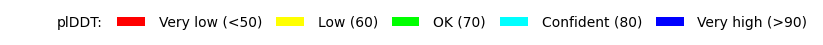

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
# import colabfold as cf
import colabfold_utils as cf
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}
cf.show_pdb(f"output/{str(num_run)}/{jobname}.pdb", show_sidechains, show_mainchains, color, chains=1, vmin=0.5, vmax=0.9).show()

if color == "lDDT": cf.plot_plddt_legend().show()

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a predicted structure in **PDB** format from the last success run

#@markdown will be automatically downloaded  to your computer with inputed sequence.
from google.colab import files
os.system(f'cd output/{str(num_runs)}/; zip -q -r ../../{config_name}.zip *')
files.download(f'{config_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>